# Imports

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import cv2
import pydot
import time
import collections
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

print(tf.__version__)
print(np.__version__)
print(pd.__version__)
print(cv2.__version__)
print(pydot.__version__)

2.4.0
1.19.5
1.1.5
4.5.1
1.4.2


# Load and Resize the data

In [2]:
#load_dataset function to load the data and resize the images to 50x50
def load_dataset(directory):
  images = []
  labels = []
  for idx, label in enumerate(uniq_labels):
    for file in os.listdir(directory + '/'+label):
      filepath = directory +'/'+ label + "/" + file
      img = cv2.resize(cv2.imread(filepath),(96,96))
      images.append(img)
      labels.append(idx)
  images = np.asarray(images)
  labels = np.asarray(labels)
  return images, labels

# Display the images

In [3]:
#display_images function to show examples
def display_images(x_data,y_data, title, display_label = True):
    x, y = x_data,y_data
    fig, axes = plt.subplots(5, 8, figsize = (18, 5))
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    fig.suptitle(title, fontsize = 18)
    for i, ax in enumerate(axes.flat):
        ax.imshow(cv2.cvtColor(x[i], cv2.COLOR_BGR2RGB))
        if display_label:
            ax.set_xlabel(uniq_labels[y[i]])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

# Load the data 

In [4]:
#loading_dataset into X_pre and Y_pre
data_dir = "E:/ENGR 895/dataset_sample/asl_train"
uniq_labels = sorted(os.listdir(data_dir))
X_pre, Y_pre = load_dataset(data_dir)
print(X_pre.shape, Y_pre.shape)

(21000, 96, 96, 3) (21000,)


# Split the data

In [5]:
#spliting dataset into 80% train, 10% validation and 10% test data
X_train, X_test, Y_train, Y_test = train_test_split(X_pre, Y_pre, train_size = 0.8)
X_test, X_eval, Y_test, Y_eval = train_test_split(X_test, Y_test, test_size = 0.5)

Train images shape (16800, 96, 96, 3) (16800,)
Test images shape (2100, 96, 96, 3) (2100,)
Evaluate image shape (2100, 96, 96, 3) (2100,)
Printing the labels ['A', 'B', 'C', 'D', 'E', 'F', 'Nothing'] 7


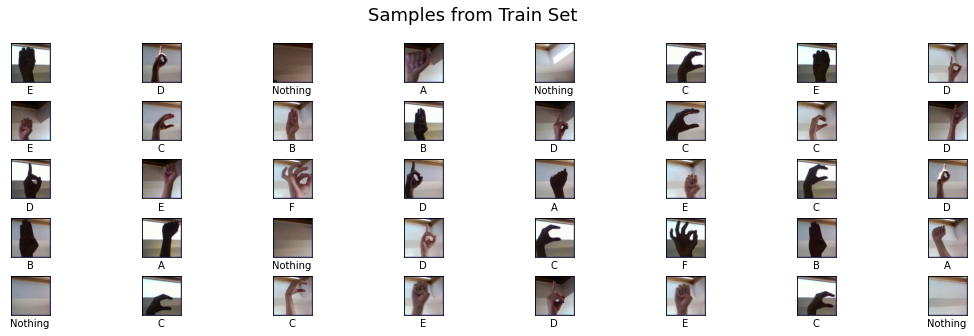

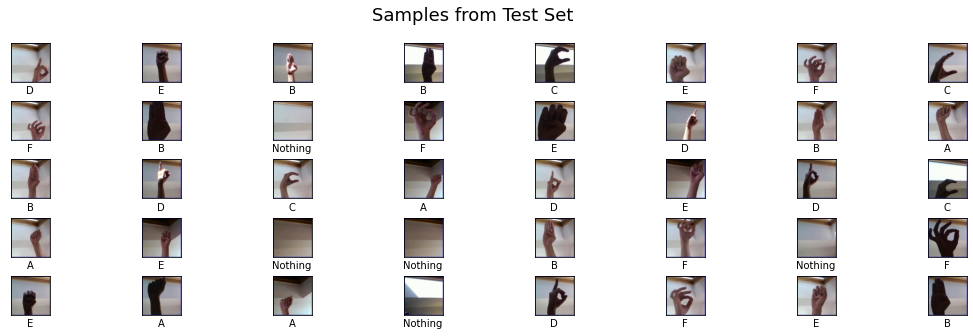

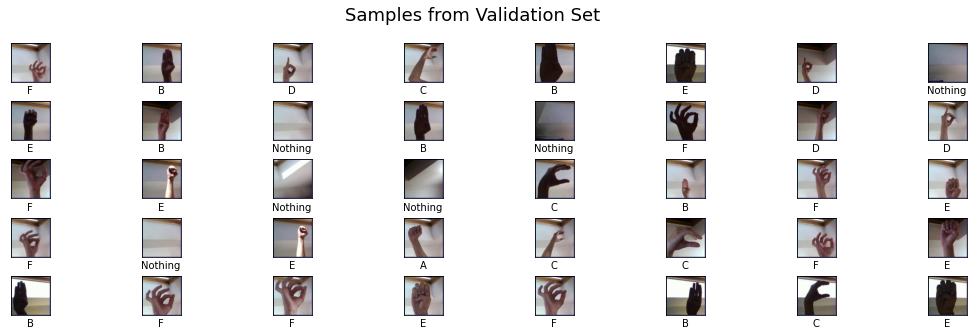

In [6]:
#print shapes and show examples for each set
print("Train images shape",X_train.shape, Y_train.shape)
print("Test images shape",X_test.shape, Y_test.shape)
print("Evaluate image shape",X_eval.shape, Y_eval.shape)
print("Printing the labels",uniq_labels, len(uniq_labels))
display_images(X_train,Y_train,'Samples from Train Set')
display_images(X_test,Y_test,'Samples from Test Set')
display_images(X_eval,Y_eval,'Samples from Validation Set')

# Normalize the data 

In [7]:
# converting Y_tes and Y_train to One hot vectors using to_categorical
# example of one hot => '1' is represented as [0. 1. 0. . . . . 0.]
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
Y_eval = to_categorical(Y_eval)
X_train = X_train / 255.
X_test = X_test/ 255.
X_eval = X_eval/ 255.

# Build the Model

In [8]:
# Load pre-trained MobileNetV2 without the top layer
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights="imagenet")

# Freeze the base model layers to retain pre-trained weights
base_model.trainable = False

# Build your custom model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
output = Dense(len(uniq_labels), activation='softmax')(x)  # Output layer

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [9]:
#compiling the model
#default batch size 32
#default learning rate is 0.001
model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'],)

In [10]:
#start training(fitting) the data
history = model.fit(X_train, Y_train, epochs=12, verbose=1,
                validation_data=(X_eval, Y_eval))

Epoch 1/12
525/525 [==============================] - 71s 132ms/step - loss: 0.3471 - accuracy: 0.8879 - val_loss: 0.0142 - val_accuracy: 0.9962
Epoch 2/12
525/525 [==============================] - 71s 136ms/step - loss: 0.0370 - accuracy: 0.9881 - val_loss: 0.0100 - val_accuracy: 0.9971
Epoch 3/12
525/525 [==============================] - 73s 138ms/step - loss: 0.0252 - accuracy: 0.9903 - val_loss: 0.0058 - val_accuracy: 0.9986
Epoch 4/12
525/525 [==============================] - 78s 149ms/step - loss: 0.0157 - accuracy: 0.9945 - val_loss: 0.0036 - val_accuracy: 0.9981
Epoch 5/12
525/525 [==============================] - 75s 143ms/step - loss: 0.0096 - accuracy: 0.9972 - val_loss: 0.0063 - val_accuracy: 0.9971
Epoch 6/12
525/525 [==============================] - 85s 161ms/step - loss: 0.0127 - accuracy: 0.9961 - val_loss: 0.0036 - val_accuracy: 0.9990
Epoch 7/12
525/525 [==============================] - 86s 163ms/step - loss: 0.0149 - accuracy: 0.9949 - val_loss: 0.0068 - val_ac

# Save the Model

In [15]:
#save the model
model.save('gesture_model_mobile.keras')

# Plot the Accuracy & Loss 

In [12]:
train_loss = history.history['loss']
print('Training Loss: ', (train_loss[11]), '%')
train_acc = history.history['accuracy']
print('Training Accuracy: ', (train_acc[11])*100, '%')
val_loss = history.history['val_loss']
print('Validation Loss: ', (val_loss[11])*100, '%')
val_accuracy = history.history['val_accuracy']
print('Validation Accuracy: ', (val_accuracy[11])*100, '%')

Training Loss:  0.010168000124394894 %
Training Accuracy:  99.6666669845581 %
Validation Loss:  0.4455841612070799 %
Validation Accuracy:  99.95238184928894 %


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




# Confusion Matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for each class
Y_pred_probs = model.predict(X_test)

# Get the predicted class indices
Y_pred = np.argmax(Y_pred_probs, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(np.argmax(Y_test, axis=1), Y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=uniq_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#save the model
model.save('gesture_model')